<a href="https://colab.research.google.com/github/shivendrra/AIVA-4x500m/blob/main/base/AIVA_500m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.8 MB/s eta 0:00:00


In [3]:
# data for model
with open('/content/drive/MyDrive/training data/consolidated_300m.txt', 'r', encoding='utf-8') as file:
  train_data = file.read()

print(f"{(len(train_data)/1e9):.2f} billion words")

1.98 billion words


In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("p50k_base")
tokenizer = tiktoken.encoding_for_model("text-davinci-003")

input_data = tokenizer.encode(train_data)
print(f"total tokens: {(len(input_data)/1e6):.0f} million")

n = int(0.9*len(input_data)) # first 90% will be train, rest val
train_data = input_data[:n]
val_data = input_data[n:]

del input_data, n

total tokens: 400 million


In [5]:
import torch

# Convert to tensors
train_data = torch.tensor(train_data, dtype=torch.long)
val_data = torch.tensor(val_data, dtype=torch.long)

print(f"train data {(len(train_data) / 1e6):.0f} million\nvalidation data {(len(val_data) / 1e6):.0f} million")
print(f"train data = {train_data[:10]}, \nval data = {val_data[:10]}")

train data 360 million
validation data 40 million
train data = tensor([ 5239,   197, 16963,   457,   197,  5239,    62, 30001,    62, 13664]), 
val data = tensor([  13,  198, 1532,  345,  561,  588,  285,    1, 1911,  198])


In [6]:
print(f"train data = {tokenizer.decode(train_data[:10].tolist())}, \nval data = {tokenizer.decode(val_data[:10].tolist())}")

train data = text	prompt	text_token_length, 
val data = .
If you would like m"".



In [7]:
# hyperparameters
batch_size = 10
block_size = 256
max_iters = 2500
eval_interval = 100
learning_rate = 3e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 250
d_model = 512
n_head = 18
n_layers = 12
dropout = 0.2
norm_eps = 1e-05

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RMSNorm(nn.Module):
  def __init__(self, dim: int, eps: float = 1e-6):
    """
      Initialize the RMSNorm normalization layer.
      Args:
        dim (int): The dimension of the input tensor.
        eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.
      Attributes:
        eps (float): A small value added to the denominator for numerical stability.
        weight (nn.Parameter): Learnable scaling parameter.
    """
    super().__init__()
    self.eps = eps
    self.weight = nn.Parameter(torch.ones(dim))

  def _norm(self, x):
    """
      Apply the RMSNorm normalization to the input tensor.
        Args:
        x (torch.Tensor): The input tensor.
      Returns:
        torch.Tensor: The normalized tensor.
    """
    return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

  def forward(self, x):
    """
      Forward pass through the RMSNorm layer.
      Args:
          x (torch.Tensor): The input tensor.
      Returns:
          torch.Tensor: The output tensor after applying RMSNorm.
    """
    output = self._norm(x.float()).type_as(x)
    return output * self.weight

class UnMaskedHead(nn.Module):
  def __init__(self, head_size, d_model, block_size, dropout):
    super().__init__()
    self.key = nn.Linear(d_model, head_size, bias=True)
    self.query = nn.Linear(d_model, head_size, bias=True)
    self.value = nn.Linear(d_model, head_size, bias=False)
    self.dropout = nn.Dropout(dropout)
    self.rel_pos_embd = nn.Parameter(torch.randn(block_size, block_size, head_size))

  def forward(self, x):
    B, T, C = x.shape
    key = self.key(x)
    query = self.query(x)

    scores = torch.matmul(query, key.transpose(-2, -1)) / (key.shape[-1] ** -0.5)
    rel_pos_scores = torch.einsum('btc,tvc->btv', query, self.rel_pos_embd[:T, :T])
    scores = scores + rel_pos_scores

    att_mat = F.softmax(scores, dim=-1)
    att_mat = self.dropout(att_mat)
    value = self.value(x)
    output = torch.matmul(att_mat, value)
    return output

class UnMaskedAttention(nn.Module):
  def __init__(self, d_model, block_size, dropout, n_head):
    head_size = d_model // n_head
    super().__init__()
    self.heads = nn.ModuleList([UnMaskedHead(d_model=d_model, dropout=dropout, block_size=block_size, head_size=head_size) for _ in range(n_head)])
    self.proj = nn.Linear(n_head * head_size, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

class MaskedHead(nn.Module):
  def __init__(self, d_model, head_size, dropout, block_size):
    super().__init__()
    self.key = nn.Linear(d_model, head_size, bias=False)
    self.query = nn.Linear(d_model, head_size, bias=False)
    self.value = nn.Linear(d_model, head_size, bias=False)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x):
    B, T, C = x.shape
    key = self.key(x)
    query = self.query(x)

    scores = torch.matmul(query, key.transpose(-2, -1)) / (key.shape[-1] ** -0.5)
    scores = scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

    att_mat = F.softmax(scores, dim=-1)
    att_mat = self.dropout(att_mat)
    value = self.value(x)
    output = torch.matmul(att_mat, value)
    return output

class CasualMaskedAttention(nn.Module):
  def __init__(self, d_model, block_size, dropout, n_head):
    head_size = d_model // n_head
    super().__init__()
    self.heads = nn.ModuleList([MaskedHead(d_model=d_model, dropout=dropout, block_size=block_size, head_size=head_size) for _ in range(n_head)])
    self.proj = nn.Linear(n_head * head_size, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

class FinalHead(nn.Module):
  def __init__(self, d_model, head_size, dropout, block_size):
    super().__init__()
    self.key = nn.Linear(d_model, head_size, bias=False)
    self.query = nn.Linear(d_model, head_size, bias=False)
    self.value = nn.Linear(d_model, head_size, bias=True)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, att):
    B, T, C = x.shape
    key = self.key(att)
    query = self.query(att)

    scores = torch.matmul(query, key.transpose(-2, -1)) / (key.shape[-1] ** -0.5)

    att_mat = F.softmax(scores, dim=-1)
    att_mat = self.dropout(att_mat)
    value = self.value(x)
    output = torch.matmul(att_mat, value)
    return output

class FinalAttention(nn.Module):
  def __init__(self, d_model, block_size, dropout, n_head):
    head_size = d_model // n_head
    super().__init__()
    self.heads = nn.ModuleList([FinalHead(d_model=d_model, dropout=dropout, block_size=block_size, head_size=head_size) for _ in range(n_head)])
    self.proj = nn.Linear(n_head * head_size, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, att):
    out = torch.cat([h(x, att) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

class FeedForward(nn.Module):
  def __init__(self, d_model, dropout):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(d_model, 4*d_model),
      nn.GELU(),
      nn.Linear(4*d_model, d_model),
      nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.net(x)

class EncoderNetwork(nn.Module):
  def __init__(self, d_model, n_head, norm_eps, dropout, block_size):
    super().__init__()
    self.s_att = UnMaskedAttention(n_head=n_head, d_model=d_model, dropout=dropout, block_size=block_size)
    self.ffwd = FeedForward(d_model, dropout)
    self.dropout = nn.Dropout(dropout)
    self.norm = RMSNorm(d_model, eps=norm_eps)

  def forward(self, src):
    src_att = self.s_att(self.norm(src))
    src_out = src + self.dropout(src_att)

    src = self.ffwd(self.norm(src_out))
    src_f = src_out + self.dropout(src)

    del src_att, src_out, src
    return src_f

class DecoderNetwork(nn.Module):
  def __init__(self, d_model, n_head, norm_eps, dropout, block_size):
    super().__init__()
    self.m_att = CasualMaskedAttention(n_head=n_head, d_model=d_model, dropout=dropout, block_size=block_size)
    self.f_att = FinalAttention(d_model=d_model, n_head=n_head, dropout=dropout, block_size=block_size)
    self.ffwd = FeedForward(d_model, dropout)
    self.dropout = nn.Dropout(dropout)
    self.norm = RMSNorm(d_model, eps=norm_eps)

  def forward(self, src, att):
    m_att_out = self.m_att(self.norm(src))
    m_out = src + self.dropout(m_att_out)

    f_out = self.f_att(self.norm(m_out), self.norm(att))
    f_out = m_out + self.dropout(f_out)

    src_f = self.ffwd(self.norm(f_out))
    src_f = f_out + self.dropout(src_f)

    del f_out, m_out, m_att_out, src, att
    return src_f

class Transformer(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    self.block_size = block_size
    self.toked_model = nn.Embedding(vocab_size, d_model)
    self.pos_encod = nn.Embedding(block_size, d_model)
    self.enc_layer = nn.ModuleList([EncoderNetwork(n_head=n_head, norm_eps=norm_eps, block_size=block_size, dropout=dropout, d_model=d_model) for _ in range(n_layers)])
    self.dec_layer = nn.ModuleList([DecoderNetwork(n_head=n_head, norm_eps=norm_eps, block_size=block_size, dropout=dropout, d_model=d_model) for _ in range(n_layers)])
    self.norm_final = RMSNorm(d_model, eps=norm_eps)
    self.linear_final = nn.Linear(d_model, vocab_size)
    self.dropout = nn.Dropout(dropout)
    self.apply(self._init_weights)

  def _init_weights(self, module):
    """
      initialize weights of linear and embedding layers

      Args:
        - module (nn.Module): the module to initialize weights for
    """
    if isinstance(module, nn.Linear):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias.data)
    elif isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, idx, targets=None):
    """
      forward pass of the transformer model

    Args:
      - idx (Tensor): input tensor representing token indices
      - targets (Tensor): target tensor for computing loss during training

    Returns:
      - logits (Tensor): output logits from the final linear layer
      - loss (Tensor): optional. computed cross-entropy loss if targets are provided, else None
    """
    B, T = idx.shape

    toked_model = self.toked_model(idx)
    pos_encod = self.pos_encod(torch.arange(T, device=device))
    x = toked_model + pos_encod

    for layer in self.enc_layer:
      x_out = layer(x)

    for layer in self.dec_layer:
      x_final = layer(x, x_out)

    x_final = self.norm_final(x_final)
    logits = self.linear_final(x_final)

    if targets is None:
      loss = None

    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens, temperature=1.0, top_k=0):
    """
      generate new tokens using the trained model

    Args:
      - idx (Tensor): input tensor representing initial token indices
      - max_new_tokens (int): max no of new tokens to generate
      - temperature (float): softmax temperature for sampling
      - top_k (int): no of top tokens to consider in sampling

    Returns:
      - generated_tokens (list): list of generated token indices
    """
    generated_tokens = []

    for _ in range(max_new_tokens):
      idx_cond = idx[:, -self.block_size:]
      logits, _ = self(idx_cond)
      logits = logits[:, -1, :]

      scaled_logits = logits / temperature
      if top_k > 0:
        scaled_logits = self._top_k_filtering(scaled_logits, top_k)

      probs = F.softmax(scaled_logits, dim=-1)
      sampled_idx = torch.multinomial(probs, num_samples=1)
      generated_tokens.append(sampled_idx.item())
      idx = torch.cat((idx, sampled_idx), dim=1)

    return generated_tokens

  def generate_masked_tokens(self, idx, masked_indices, temperature=1.0, top_k=0):
    """
      Generate predictions for masked tokens using the trained model.

      Args:
        - idx (Tensor): input tensor representing token indices
        - masked_indices (Tensor): tensor of indices indicating masked positions
        - temperature (float): softmax temperature for sampling
        - top_k (int): no of top tokens to consider in sampling

      Returns:
        - predicted_tokens (Tensor): tensor of predicted token indices
    """
    B, T = idx.shape

    toked_model = self.toked_model(idx)
    pos_encod = self.pos_encod(torch.arange(T, device=device))
    x = toked_model + pos_encod

    for layer in self.enc_layer:
      x_out = layer(x)

    for layer in self.dec_layer:
      x_final = layer(x, x_out)

    x_masked = x_final.clone()
    x_masked[masked_indices] = self.toked_model(torch.tensor([6], device=device))

    x_masked = self.norm_final(x_masked)
    logits = self.linear_final(x_masked)

    masked_logits = logits[masked_indices].view(-1, logits.size(-1))
    scaled_logits = masked_logits / temperature
    if top_k > 0:
      scaled_logits = self._top_k_filtering(scaled_logits, top_k)

    probs = F.softmax(scaled_logits, dim=-1)
    predicted_indices = torch.argmax(probs, dim=-1)

    return predicted_indices

  def _top_k_filtering(self, logits, top_k):
    """
      filter logits to keep only the top-k tokens

    Args:
      - logits (Tensor): input tensor representing unscaled logits
      - top_k (int): no of top tokens to keep

    Returns:
      - filtered_logits (Tensor): filtered logits with only top-k tokens remaining
    """
    values, indices = torch.topk(logits, top_k, dim=-1)
    min_value = values[:, -1].unsqueeze(-1).expand_as(logits)
    filtered_logits = torch.where(logits < min_value, torch.ones_like(logits) * -float('inf'), logits)

    return filtered_logits

In [9]:
"""
  use this file to train the model

  working:
    - imports vatious dependencies first, and then loads the training data
    - tokenizes it, per-character basis
    - loads the required hyper-parameters and the model file
    - trains it till 'max_iters' and saves the model state, and generates outputs

  with the current set configuration, model can reach upto ~60million parameters
  and can become ~99% accurate with next token prediction
"""

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

vocab_size = tokenizer.n_vocab
model = Transformer(vocab_size)
checkpoint_path = '/content/drive/MyDrive/base-500m.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
m = model.to(device)

# no of parameters
n_param = sum(p.numel() for p in m.parameters())/1e6
print(f"vocab size: {vocab_size}")
print(f"{n_param:.0f} million parameters")
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

steps = []
train_losses = []
val_losses = []

for iter in range(max_iters):

  if iter % eval_interval == 0 or iter == max_iters - 1:
    losses = estimate_loss()
    print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    steps.append(iter)
    train_losses.append(losses['train'])
    val_losses.append(losses['val'])

  xb, yb = get_batch('train')
  logits, loss = model(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

vocab size: 50281
536 million parameters
step 0: train loss 5.4611, val loss 5.7733
step 100: train loss 5.4859, val loss 5.7609
step 200: train loss 5.4366, val loss 5.7421
step 300: train loss 5.4118, val loss 5.7483
step 400: train loss 5.3847, val loss 5.7439
step 500: train loss 5.3921, val loss 5.7199
step 600: train loss 5.3781, val loss 5.7384
step 700: train loss 5.4029, val loss 5.7142
step 800: train loss 5.3649, val loss 5.6579
step 900: train loss 5.3712, val loss 5.6517
step 1000: train loss 5.3437, val loss 5.6734
step 1100: train loss 5.3674, val loss 5.6478
step 1200: train loss 5.3534, val loss 5.6327
step 1300: train loss 5.2754, val loss 5.6200
step 1400: train loss 5.2781, val loss 5.6002
step 1500: train loss 5.2356, val loss 5.5554
step 1600: train loss 5.1945, val loss 5.5598
step 1700: train loss 5.2314, val loss 5.5781
step 1800: train loss 5.2540, val loss 5.5091
step 1900: train loss 5.2265, val loss 5.5613
step 2000: train loss 5.2028, val loss 5.5447
step 

In [10]:
model_save_name = f'base-500m-v1.pth'
path = f"/content/drive/MyDrive/{model_save_name}"
torch.save(model.state_dict(), path)

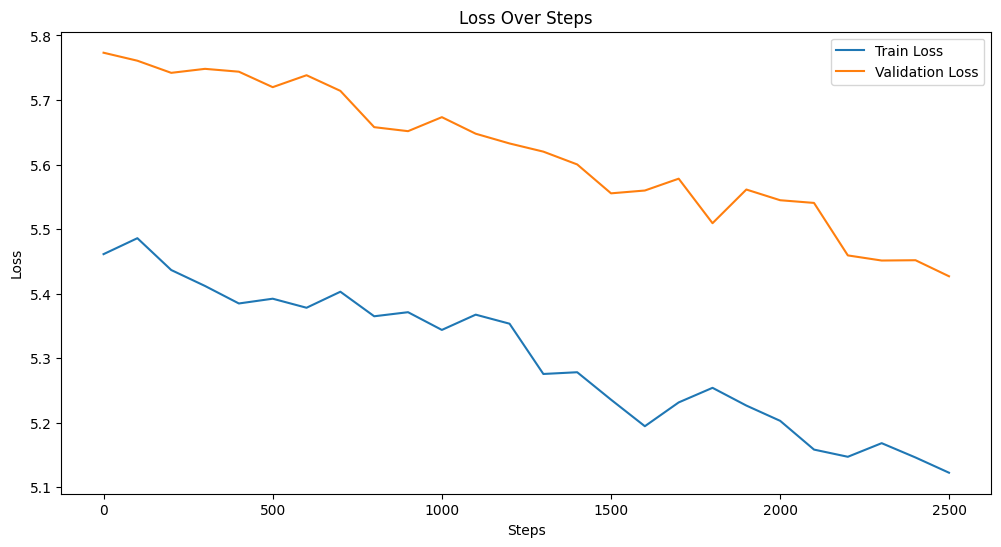

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.title('Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
# testing
target_text = "I was in the market when"
context = torch.tensor([tokenizer.encode(target_text)], dtype=torch.long, device=device)
generated_output = tokenizer.decode(m.generate(context, max_new_tokens=50))
print(target_text, generated_output)

I was in the market when  makes plant. Also, my current the planet, the safety rhythm of its importance of two emotional food tragedy of the profits agencies. series, and offer about presenting activities caused in all, complete, where the window and let's one exams that curious single


In [13]:
# 8-bit quantization

import torch
import torch.quantization

# model = Transformer(vocab_size=9)
# checkpoint_path = '/content/drive/MyDrive/enigma-2.5b.pth'
# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint)
# model = model.to(device)

quantized_model = torch.quantization.quantize_dynamic(
  model,
  dtype=torch.qint8
)

In [14]:
model_save_name = f'base-8bit.pth'
path = f"/content/drive/MyDrive/{model_save_name}"
torch.save(quantized_model.state_dict(), path)

print("Quantized model saved successfully.")

Quantized model saved successfully.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu Mar 28 11:01:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              31W /  70W |   6969MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--